In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import pathlib
from scipy import signal
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [46]:
#Parameters settings
batch_size = 16

In [47]:
#Pipeline definition
train_folder = pathlib.Path("/home/jupyter/instruments/npy")

# Convert all paths into a string
files_path = [str(sound_path) for sound_path in list(train_folder.glob("*/*"))]
data_spec = tf.data.Dataset.from_tensor_slices(files_path)


#labels
labels_dict = {'cel':0,'cla':1,'flu':2,
               'gac':3,'gel':4,'org':5,
               'pia':6,'sax':7,'tru':8,
               'vio':9,'voi':10}

labels_dict_rev = {0:'cel',1:'cla',2:'flu',
               3:'gac',4:'gel',5:'org',
               6:'pia',7:'sax',8:'tru',
               9:'vio',10:'voi'}
               
labels = [labels_dict[str(sound_path.parent.name)] for sound_path in list(train_folder.glob("*/*"))]
label = tf.data.Dataset.from_tensor_slices(labels)

#Shuffle before mapping, to avoid memory saturation (same seed insure the correspondance)
data_spec = data_spec.shuffle(len(files_path),seed = 42)
label = label.shuffle(len(files_path),seed = 42)

# Mapping of train files
def read_npy_file(item):
    data = np.load(item.numpy().decode())
    return data.astype(np.float32)

shape = np.load(files_path[0]).shape

data_spec = data_spec.map(lambda item: tf.ensure_shape(tf.py_function(read_npy_file, [item], [tf.float32,])[0],shape))

#zip
full_ds = tf.data.Dataset.zip((data_spec,label)).batch(batch_size = batch_size,drop_remainder = True)

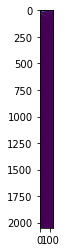

In [4]:
iterator = iter(full_ds)
for i in range(0,1):
    batch = next(iterator)
    stft_amp = batch[0][1]
    stft_amp.shape
    plt.imshow(tf.reshape(stft_amp,(2049,126)))

In [5]:
# model inititialization

model_name = 'instrument_classifier_LSTM_wav_dp'
checkpoint_path = '/home/jupyter/{}.h5'.format(model_name)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weight_only = False,
                                                 verbose = 1)

# Model construction

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D,Reshape,Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D,BatchNormalization,LSTM
from tensorflow.keras.models import Model,Sequential

shape = (2049,126,1)
batch_size = 16

#Classical classification convolutional model
input_layer = Input(shape=shape,batch_size = batch_size)

group1_Conv = Conv2D(filters = 8,kernel_size = (16,2),padding='same',activation='relu')
group1_Pool = MaxPooling2D(pool_size = (6,2))
group1_Norm = BatchNormalization()
drop1 = Dropout(0.2)

group2_Conv = Conv2D(filters = 8,kernel_size = (16,2),padding='same',activation='relu')
group2_Pool = MaxPooling2D(pool_size = (6,2))
group2_Norm = BatchNormalization()
drop2 = Dropout(0.2)

group3_Conv = Conv2D(filters = 16,kernel_size = (16,2),padding='same',activation='relu')
group3_Pool = MaxPooling2D(pool_size = (2,2))
group3_Norm = BatchNormalization()
drop3 = Dropout(0.2)

out_reshape = Reshape((15,-1))

out_LSTM = LSTM(units = 11,activation = 'sigmoid')

instruments_classifier = Sequential([input_layer,
                                  group1_Conv,
                                  group1_Pool,
                                  group1_Norm,
                                     drop1,
                                  group2_Conv,
                                  group2_Pool,
                                  group2_Norm,
                                     drop2,
                                  group3_Conv,
                                  group3_Pool,
                                  group3_Norm,
                                     drop3,
                                  out_reshape,
                                  out_LSTM])

# model parametrization
try:
    instruments_classifier.load_weights(checkpoint_path)
    init = False
except OSError:
    init = True

#learning rate
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=6000,
    decay_rate=0.90,
    staircase=True)

# Optimizer
optimizer = tf.keras.optimizers.Adam(lr_schedule)

#Loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()

#Compile
instruments_classifier.compile(optimizer = optimizer,loss = loss,metrics = [metric])


In [6]:
instruments_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (16, 2049, 126, 8)        264       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 341, 63, 8)          0         
_________________________________________________________________
batch_normalization (BatchNo (16, 341, 63, 8)          32        
_________________________________________________________________
dropout (Dropout)            (16, 341, 63, 8)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 341, 63, 8)          2056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 56, 31, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (16, 56, 31, 8)           3

In [7]:
# train_test_split
n = int(len(labels)/16*2/3)
train_ds = full_ds.take(n)
test_ds = full_ds.skip(n)

In [16]:
for batch in test_ds.take(1):
    print(batch[1])

tf.Tensor([ 2 10  9  9  6  4  8  6  8  4  4  1  2  7  2  4], shape=(16,), dtype=int32)


In [18]:
instruments_classifier.evaluate(test_ds),instruments_classifier.evaluate(train_ds)

279/279 [==============================] - 7s 24ms/step - loss: 2.3172 - sparse_categorical_accuracy: 0.1387


([2.314114626816341, 0.14419644], [2.3171536948091243, 0.13866487])

In [67]:
instruments_classifier.fit(train_ds,epochs=100,
                        validation_data=test_ds,
                        verbose = 1,
                        callbacks=[cp_callback])

Train for 279 steps, validate for 140 steps
Epoch 1/100
277/279 [============================>.] - ETA: 0s - loss: 0.8276 - sparse_categorical_accuracy: 0.7292
Epoch 00001: saving model to /home/jupyter/instrument_classifier_LSTM_wav_dp.h5
279/279 [==============================] - 17s 62ms/step - loss: 0.8270 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.7287 - val_sparse_categorical_accuracy: 0.7647
Epoch 2/100
277/279 [============================>.] - ETA: 0s - loss: 0.8146 - sparse_categorical_accuracy: 0.7338
Epoch 00002: saving model to /home/jupyter/instrument_classifier_LSTM_wav_dp.h5
279/279 [==============================] - 17s 62ms/step - loss: 0.8160 - sparse_categorical_accuracy: 0.7334 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.7920
Epoch 3/100
277/279 [============================>.] - ETA: 0s - loss: 0.8041 - sparse_categorical_accuracy: 0.7362
Epoch 00003: saving model to /home/jupyter/instrument_classifier_LSTM_wav_dp.h5
279/279 [=================

In [43]:
def test_formating(path):

    n_fft = 4096
    hop_length = int(n_fft/4)
    channels = 1 # 2 for stereo

    filepath = path
    audio_binary = tf.io.read_file(filepath)
    waveform = tf.audio.decode_wav(audio_binary,
                                    desired_channels = 1)

    file = next(iter(waveform))
    out = []
    lenght = 132299
    for i in range(0,min(int(len(file)/lenght),16)):
        start = i*lenght
        end = (i+1)*lenght
        out.append(file[start:end,:])

    empty_file = tf.constant([[0.0] for i in range(0,lenght)])
    save = len(out)
    while len(out) < 16:
        out.append(empty_file)
    
    out_stft = []
    for extract in out:
        signal = tf.reshape(extract,[channels,-1])

        stft = tf.signal.stft(signal,
                            frame_length=n_fft,
                            frame_step = hop_length)
        stft_amp = tf.abs(stft)
        stft_amp = tf.transpose(stft_amp,perm=[2,1,0])
        out_stft.append(stft_amp)
    batched = tf.data.Dataset.from_tensor_slices(out_stft).batch(16)
    fichier = open(filepath[:-4] + '.txt')
    prediction = []
    for line in fichier:
        prediction.append(labels_dict[line.rstrip('\n').rstrip('\t')])
    return batched,prediction,save

In [64]:
import pathlib
folders = ['/home/jupyter/IRMA_test_1/IRMAS-TestingData-Part1/IRMAS-TestingData-Part1/Part1',
           '/home/jupyter/IRMA_test_2/IRMAS-TestingData-Part2/IRMAS-TestingData-Part2/Part2',
           '/home/jupyter/IRMA_test_3/IRMAS-TestingData-Part3/IRMAS-TestingData-Part3/Part3']

resume = []

for folder in folders:
    y_true = []
    y_pred = []    
    n=0
    folder_path = pathlib.Path(folder)
    files_path = [str(path) for path in folder_path.glob('*.wav')]
    print(len(files_path))
    for file_path in files_path:
        batch,cat,save = test_formating(file_path)
        prediction = instruments_classifier.predict(batch)
        
        out = prediction[0]
        for i in range(1,save):
            out = out + prediction[i]
        predicted = list(out).index(max(out))
        
        if predicted in cat:
            y_true.append(predicted)
            y_pred.append(predicted)
        else:
            y_true.append(cat[0])
            y_pred.append(predicted)
        print(n,end = '\r')
        n+=1
    resume.append([y_true,y_pred])


1301


In [51]:
len(resume[0])

2

In [65]:
y_true_test = resume[0][0] + resume [3][0] + resume[2][0]
y_pred_test = resume[0][1] + resume [3][1] + resume[2][1]

In [53]:
y_true_train = []
y_pred_train = []

for batch in test_ds:
    prediction = instruments_classifier.predict(batch)
    predicted = [list(y).index(max(y)) for y in prediction]
    labels = list(batch[1].numpy())
    y_true_train = y_true_train + labels
    y_pred_train = y_pred_train + predicted

In [54]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

accuracy:  0.7879464285714286
f1:  0.7703096906396
recall:  0.7779551743970444


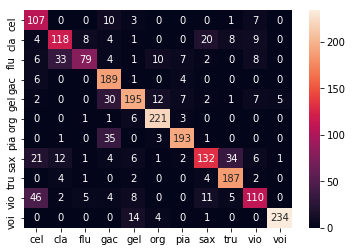

In [58]:
out = list(range(11))
for i in labels_dict_rev:
    out[i] = labels_dict_rev[i]
y_true,y_pred = y_true_train,y_pred_train
sns.heatmap(confusion_matrix(y_true,y_pred),annot = True,xticklabels = out,yticklabels = out,fmt = 'd')
print('accuracy: ',accuracy_score(y_true,y_pred))
print('f1: ',f1_score(y_true,y_pred,average = 'macro'))
print('recall: ',recall_score(y_true,y_pred,average = 'macro'))

accuracy:  0.6454418928322895
f1:  0.5493042464083465
recall:  0.6201443225769379


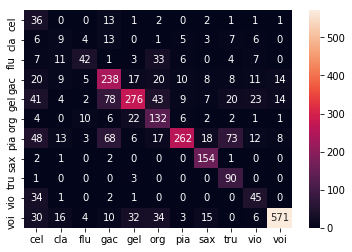

In [66]:
out = list(range(11))
for i in labels_dict_rev:
    out[i] = labels_dict_rev[i]
y_true,y_pred = y_true_test,y_pred_test
sns.heatmap(confusion_matrix(y_true,y_pred),annot = True,xticklabels = out,yticklabels = out,fmt = 'd')
print('accuracy: ',accuracy_score(y_true,y_pred))
print('f1: ',f1_score(y_true,y_pred,average = 'macro'))
print('recall: ',recall_score(y_true,y_pred,average = 'macro'))

In [63]:
print(len(resume[0][1]),len(resume[1][1]),len(resume[2][1]))

807 0 766
